In [1]:
NUM_ITERATIONS_TO_PLOT = 100

In [2]:
wandb_entity = "harvardparkesateams"
group_name = "tinystories"

run_groups_to_fetch = [
    "tinystories",
    # "tinystories_1_matthias_8k_1epoch_llama",
    # "tinystories_1_matthias_8k_1epoch_llama42M_snap",
    # "tinystories_1_matthias_8k_1epoch_llama125M_nlp",
    # "tinystories_5_matthias_8k_3epoch_new",
    # "tinystories_5_matthias_8k_1epoch_new",
    # "tinystories_1_matthias_8k_1epoch_subsample",
    # "tinystories_llama_firstiter",
]

In [3]:
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.scale
import matplotlib.ticker
import matplotlib.transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns


sns.set_style("whitegrid")


# Enable LaTeX rendering.
# https://stackoverflow.com/a/23856968
# plt.rc('text', usetex=True)
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Computer Modern"
# Can add more commands to this list
plt.rcParams["text.latex.preamble"] = "\n".join([r"\usepackage{amsmath}"])
# Increase font size.
plt.rcParams["font.size"] = 23

In [4]:
from datetime import datetime
import joblib
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import wandb


import src.plot

In [5]:
# Create API to retrieve the runs from wandb
api = wandb.Api(timeout=100)

In [6]:
# Get the current date and time
# query_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
# query_datetime = "20240327_185710"
# query_datetime = "20240329_220900"
query_datetime = "20241001"
plot_dir = "results"
data_dir = "data"
os.makedirs(plot_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)


def load_data(group_name, query_datetime, data_dir: str = "data"):
    print(f"Loading data for group {group_name} at t= {query_datetime}.")
    os.makedirs(data_dir, exist_ok=True)
    cached_results_path = os.path.join(
        data_dir, f"cache_{group_name}_{query_datetime}.joblib"
    )
    if os.path.exists(cached_results_path):
        cached_results = joblib.load(cached_results_path)
        # Load data from cache if the file exists
        data_inner = cached_results["df_inner"]
        data_outer = cached_results["df_outer"]
        print(f"Loaded data_inner and data_outer for group {group_name} from disk.")
    else:
        print(
            f"Data for group {group_name} at t= {query_datetime} not found. Fetching data from W&B API."
        )

        # Your existing code to fetch data from the API
        runs = api.runs(
            f"{wandb_entity}/model_collapse_part_2",
            filters={
                "group": group_name,
            },
        )

        data_inner = []
        data_outer = []
        model_num_parameters = None

        # Iterate over the runs and extract the required data
        for run in runs:
            if "dataset_mode" in run.config and "model_num_parameters" in run.config:
                dataset_mode = run.config["dataset_mode"]
                model_num_parameters = run.config["model_num_parameters"]
                model = run.config["model"]
                history = run.scan_history(page_size=100000)
                run_config = {
                    "temperature": run.config["full_cli_args"][
                        "generation_temperature"
                    ],
                    "model": model,
                    "model_num_parameters": model_num_parameters,
                    "dataset_mode": dataset_mode,
                    "run_group": group_name,
                    "run_id": run.id,
                    "dataset_fraction": (
                        run.config["dataset_fraction"]
                        if run.config["dataset_fraction"] is not None
                        else 1.0
                    ),
                    "generation_strategy": (
                        run.config["full_cli_args"]["generation_strategy"]
                    ),
                    "num_epochs": run.config["epochs"],
                    "firstiter_steps": run.config["full_cli_args"].get(
                        "num_steps_first_iter", -1
                    ),
                    "hyperparameters": f"{model}_{model_num_parameters}_frac{run.config['dataset_fraction'] if run.config['dataset_fraction'] is not None else 1.0}_epochs{run.config['epochs']}_temp{run.config['full_cli_args']['generation_temperature']}",
                }
                for row in history:
                    try:
                        if row["is_outer"] is True:
                            data_outer.append(
                                {
                                    "step": row["_step"],
                                    "iteration": row.get("iteration", np.nan),
                                    "trainer_global_step": row.get(
                                        "trainer_global_step", np.nan
                                    ),
                                    "eval_loss_outer": row.get(
                                        "eval_loss_outer", np.nan
                                    ),
                                    "eval_perplexity_outer": row.get(
                                        "eval_perplexity_outer", np.nan
                                    ),
                                    **run_config,
                                }
                            )
                        else:
                            data_inner.append(
                                {
                                    "step": row["_step"],
                                    "loss": row.get("loss", np.nan),
                                    "eval_loss": row.get("eval_loss", np.nan),
                                    "iteration": row.get("iteration", np.nan),
                                    "trainer_global_step": row.get(
                                        "trainer_global_step", np.nan
                                    ),
                                    "epoch": row["epoch"],
                                    **run_config,
                                }
                            )
                    except KeyError as ke:
                        print(f"KeyError {ke} in run {run.id}, row {row}.")

        # df_inner = pd.DataFrame(data_inner)
        # df_outer = pd.DataFrame(data_outer)

        # Save the DataFrames to cache as CSV files
        cached_results = {
            "df_inner": data_inner,
            "df_outer": data_outer,
        }
        joblib.dump(cached_results, filename=cached_results_path)

        print(
            f"Data for group {group_name} at t=  {query_datetime} fetched from W&B API and written to disk."
        )

    return data_inner, data_outer


# Load or fetch the data
data_inner = []
data_outer = []
for group_name in run_groups_to_fetch:
    data_inner_group, data_outer_group = load_data(
        group_name, query_datetime, data_dir=data_dir
    )
    data_inner.extend(data_inner_group)
    data_outer.extend(data_outer_group)

df_inner = pd.DataFrame(data_inner)
df_outer = pd.DataFrame(data_outer)


# Skip this, not sure why I even ran this.
df_inner = df_inner[df_inner["hyperparameters"] != "gpt2_8890880_frac5_epochs3_temp0.3"]
df_outer = df_outer[df_outer["hyperparameters"] != "gpt2_8890880_frac5_epochs3_temp0.3"]

# Skip subsample run with wrong batch size
df_inner = df_inner[df_inner["run_id"] != "dty86yke"]
df_outer = df_outer[df_outer["run_id"] != "dty86yke"]
df_inner = df_inner[df_inner["run_id"] != "3ov1gya8"]
df_outer = df_outer[df_outer["run_id"] != "3ov1gya8"]


df_inner["dataset_mode"] = df_inner["dataset_mode"].map(
    {
        "concatenate": "Accumulate",
        "replace": "Replace",
        "replace_multiple": "Replace (Multiple)",
        "concatenate_subsample": "Accumulate-Subsample",
    }
)

df_outer["dataset_mode"] = df_outer["dataset_mode"].map(
    {
        "concatenate": "Accumulate",
        "replace": "Replace",
        "replace_multiple": "Replace (Multiple)",
        "concatenate_subsample": "Accumulate-Subsample",
    }
)

# def construct_model_name(row):
#     if row["model"] == "gpt2":
#         model_name_str = "GPT-2-8M"
#     elif row["run_group"] == "tinystories_1_matthias_8k_1epoch_llama42M_snap":
#         model_name_str = "Llama-2-42M"
#     elif row["run_group"] == "tinystories_1_matthias_8k_1epoch_llama125M_nlp":
#         model_name_str = "Llama-2-125M"
#     elif row["run_group"] == "tinystories_1_matthias_8k_1epoch_llama":
#         model_name_str = "Llama-2-12M"
#     else:
#         raise ValueError(f"Unknown model: {row['model']}")
#     return f"{model_name_str} ({row['model_num_parameters']/1e6:.0f}M)"


def construct_model_name(row):
    if row["model"] == "gpt2":
        return "GPT-2 (9M)"
    elif row["model"] == "llama2":
        return "Llama-2 (12M)"
    elif row["model"] == "llama2-42M":
        return "Llama-2 (42M)"
    elif row["model"] == "llama2-125M":
        return "Llama-2 (126M)"
    else:
        raise ValueError(f"Unknown model: {row['model']}")
    return f"{model_name_str} ({row['model_num_parameters']/1e6:.0f}M)"


df_inner["Model"] = df_inner.apply(lambda row: construct_model_name(row=row), axis=1)
df_outer["Model"] = df_outer.apply(lambda row: construct_model_name(row=row), axis=1)

# hyperparams_to_nice_model_name = {
#     'gpt2_8890880_frac1.0_epochs1_temp0.3': 'GPT-2-9M (temp=0.3)',
#     'gpt2_8890880_frac1.0_epochs1_temp1': 'GPT-2-9M',
#     'llama2_12488960_frac1.0_epochs1_temp1': 'Llama-2-12M',
#     'llama2_41755136_frac1.0_epochs1_temp1': 'Llama-2-42M',
#     'llama2_125553408_frac1.0_epochs1_temp1': 'Llama-2-125M',
#     'gpt2_8890880_frac5_epochs3_temp0.3': 'GPT-2-8M (temp=0.3, small dataset, 3 epochs)',
#     'gpt2_8890880_frac5_epochs3_temp1': 'GPT-2-8M (small dataset, 3 epochs)',
#     'gpt2_8890880_frac5_epochs1_temp1': 'GPT-2-8M (small dataset)'
# }

hyperparams_to_nice_model_name = {
    "gpt2_8890880_frac1.0_epochs1_temp0.3": " (temp=0.3)",
    "gpt2_8890880_frac1.0_epochs1_temp1": "",
    "llama2_12488960_frac1.0_epochs1_temp1": "",
    "llama2_41755136_frac1.0_epochs1_temp1": "",
    "llama2_125553408_frac1.0_epochs1_temp1": "",
    "gpt2_8890880_frac5_epochs3_temp0.3": " (temp=0.3, small dataset, 3 epochs)",
    "gpt2_8890880_frac5_epochs3_temp1": " (small dataset, 3 epochs)",
    "gpt2_8890880_frac5_epochs1_temp1": " (small dataset)",
}


def construct_model_name_long(row):
    return row["Model"]
    if (
        row["hyperparameters"].startswith("gpt2_8890880_frac1.0_epochs1_temp")
        and not row["hyperparameters"] in hyperparams_to_nice_model_name
    ):
        model_name_str = row["Model"] + "(" + str(row["temperature"]) + ")"
    elif row["hyperparameters"] in hyperparams_to_nice_model_name:
        model_name_str = (
            row["Model"] + hyperparams_to_nice_model_name[row["hyperparameters"]]
        )
    else:
        raise ValueError(f"Unknown model: {row['model']}")
    return model_name_str


df_inner["Model (long)"] = df_inner.apply(
    lambda row: construct_model_name_long(row=row), axis=1
)
df_outer["Model (long)"] = df_outer.apply(
    lambda row: construct_model_name_long(row=row), axis=1
)

Loading data for group tinystories at t= 20241001.
Data for group tinystories at t= 20241001 not found. Fetching data from W&B API.
Data for group tinystories at t=  20241001 fetched from W&B API and written to disk.


In [7]:
df_inner["run_id"].unique()

array(['13l66wpw', 'kht4g1qx', 'cdhf99ml', '67zs2v8c', '5fq9g749',
       'dkayk5me', 'mmaj1xyc', '886ef2n9', 'jfrxq8h4', '984nwhql',
       '3eqk3tcq', 'rj0agnxk'], dtype=object)

In [8]:
df_inner["Model (long)"].unique()

array(['GPT-2 (9M)', 'Llama-2 (12M)', 'Llama-2 (42M)', 'Llama-2 (126M)'],
      dtype=object)

In [9]:
df_inner.head()

,step,loss,eval_loss,iteration,trainer_global_step,epoch,temperature,model,model_num_parameters,dataset_mode,run_group,run_id,dataset_fraction,generation_strategy,num_epochs,firstiter_steps,hyperparameters,Model,Model (long)
0,662,5.3256,4.204082,0,662,0.01,1,gpt2,8890880,Replace,tinystories,13l66wpw,1.0,first_token_inclusive,1,0,gpt2_8890880_frac1.0_epochs1_temp1,GPT-2 (9M),GPT-2 (9M)
1,1324,3.9764,3.706779,0,1324,0.02,1,gpt2,8890880,Replace,tinystories,13l66wpw,1.0,first_token_inclusive,1,0,gpt2_8890880_frac1.0_epochs1_temp1,GPT-2 (9M),GPT-2 (9M)
2,1986,3.6200,3.439449,0,1986,0.03,1,gpt2,8890880,Replace,tinystories,13l66wpw,1.0,first_token_inclusive,1,0,gpt2_8890880_frac1.0_epochs1_temp1,GPT-2 (9M),GPT-2 (9M)
3,2648,3.3920,3.237477,0,2648,0.04,1,gpt2,8890880,Replace,tinystories,13l66wpw,1.0,first_token_inclusive,1,0,gpt2_8890880_frac1.0_epochs1_temp1,GPT-2 (9M),GPT-2 (9M)
4,3310,3.2303,3.090990,0,3310,0.05,1,gpt2,8890880,Replace,tinystories,13l66wpw,1.0,first_token_inclusive,1,0,gpt2_8890880_frac1.0_epochs1_temp1,GPT-2 (9M),GPT-2 (9M)


In [10]:
df_outer.head()

,step,iteration,trainer_global_step,eval_loss_outer,eval_perplexity_outer,temperature,model,model_num_parameters,dataset_mode,run_group,run_id,dataset_fraction,generation_strategy,num_epochs,firstiter_steps,hyperparameters,Model,Model (long)
0,66235,0,66235,1.814903,6.140483,1,gpt2,8890880,Replace,tinystories,13l66wpw,1.0,first_token_inclusive,1,0,gpt2_8890880_frac1.0_epochs1_temp1,GPT-2 (9M),GPT-2 (9M)
1,132469,1,66234,2.072139,7.941789,1,gpt2,8890880,Replace,tinystories,13l66wpw,1.0,first_token_inclusive,1,0,gpt2_8890880_frac1.0_epochs1_temp1,GPT-2 (9M),GPT-2 (9M)
2,198703,2,66234,2.205194,9.072013,1,gpt2,8890880,Replace,tinystories,13l66wpw,1.0,first_token_inclusive,1,0,gpt2_8890880_frac1.0_epochs1_temp1,GPT-2 (9M),GPT-2 (9M)
3,264937,3,66234,2.303524,10.009396,1,gpt2,8890880,Replace,tinystories,13l66wpw,1.0,first_token_inclusive,1,0,gpt2_8890880_frac1.0_epochs1_temp1,GPT-2 (9M),GPT-2 (9M)
4,331171,4,66234,2.394362,10.961208,1,gpt2,8890880,Replace,tinystories,13l66wpw,1.0,first_token_inclusive,1,0,gpt2_8890880_frac1.0_epochs1_temp1,GPT-2 (9M),GPT-2 (9M)


In [11]:
col_order = ["Replace", "Accumulate-Subsample", "Accumulate"]  # , "Replace (Multiple)"

In [12]:
# Filter the DataFrame for trainer global step vs eval loss plot
df_trainer_eval_loss = df_inner[
    [
        "trainer_global_step",
        "eval_loss",
        "loss",
        "iteration",
        "dataset_mode",
        "epoch",
        "temperature",
        "model",
        "model_num_parameters",
        "run_group",
        "Model",
        "Model (long)",
        "generation_strategy",
    ]
].dropna()

# df_trainer_eval_loss = df_trainer_eval_loss[
#     df_trainer_eval_loss["temperature"] == 1.0
# ]

# df_trainer_eval_loss = df_trainer_eval_loss[
#     df_trainer_eval_loss["generation_strategy"] == "first_token_inclusive"
#     # df_trainer_eval_loss["generation_strategy"] == "bos_fixed_length"
# ]

df_trainer_eval_loss = df_trainer_eval_loss[
    df_trainer_eval_loss["iteration"] < NUM_ITERATIONS_TO_PLOT
]


# We use 1-based indexing in the mathematical notation.
df_trainer_eval_loss["iteration"] += 1


# Rename column from "iteration" to "Iteration" for nicer plotting.
df_trainer_eval_loss = df_trainer_eval_loss.rename(
    columns={"iteration": "Iteration", "temperature": "Temperature"}
)

Plotted results/part2_eval_loss_linear_vs_epoch_linear_col_iteration_20241001.pdf
Plotted results/part2_eval_loss_linear_vs_epoch_linear_col_iteration_20241001.png


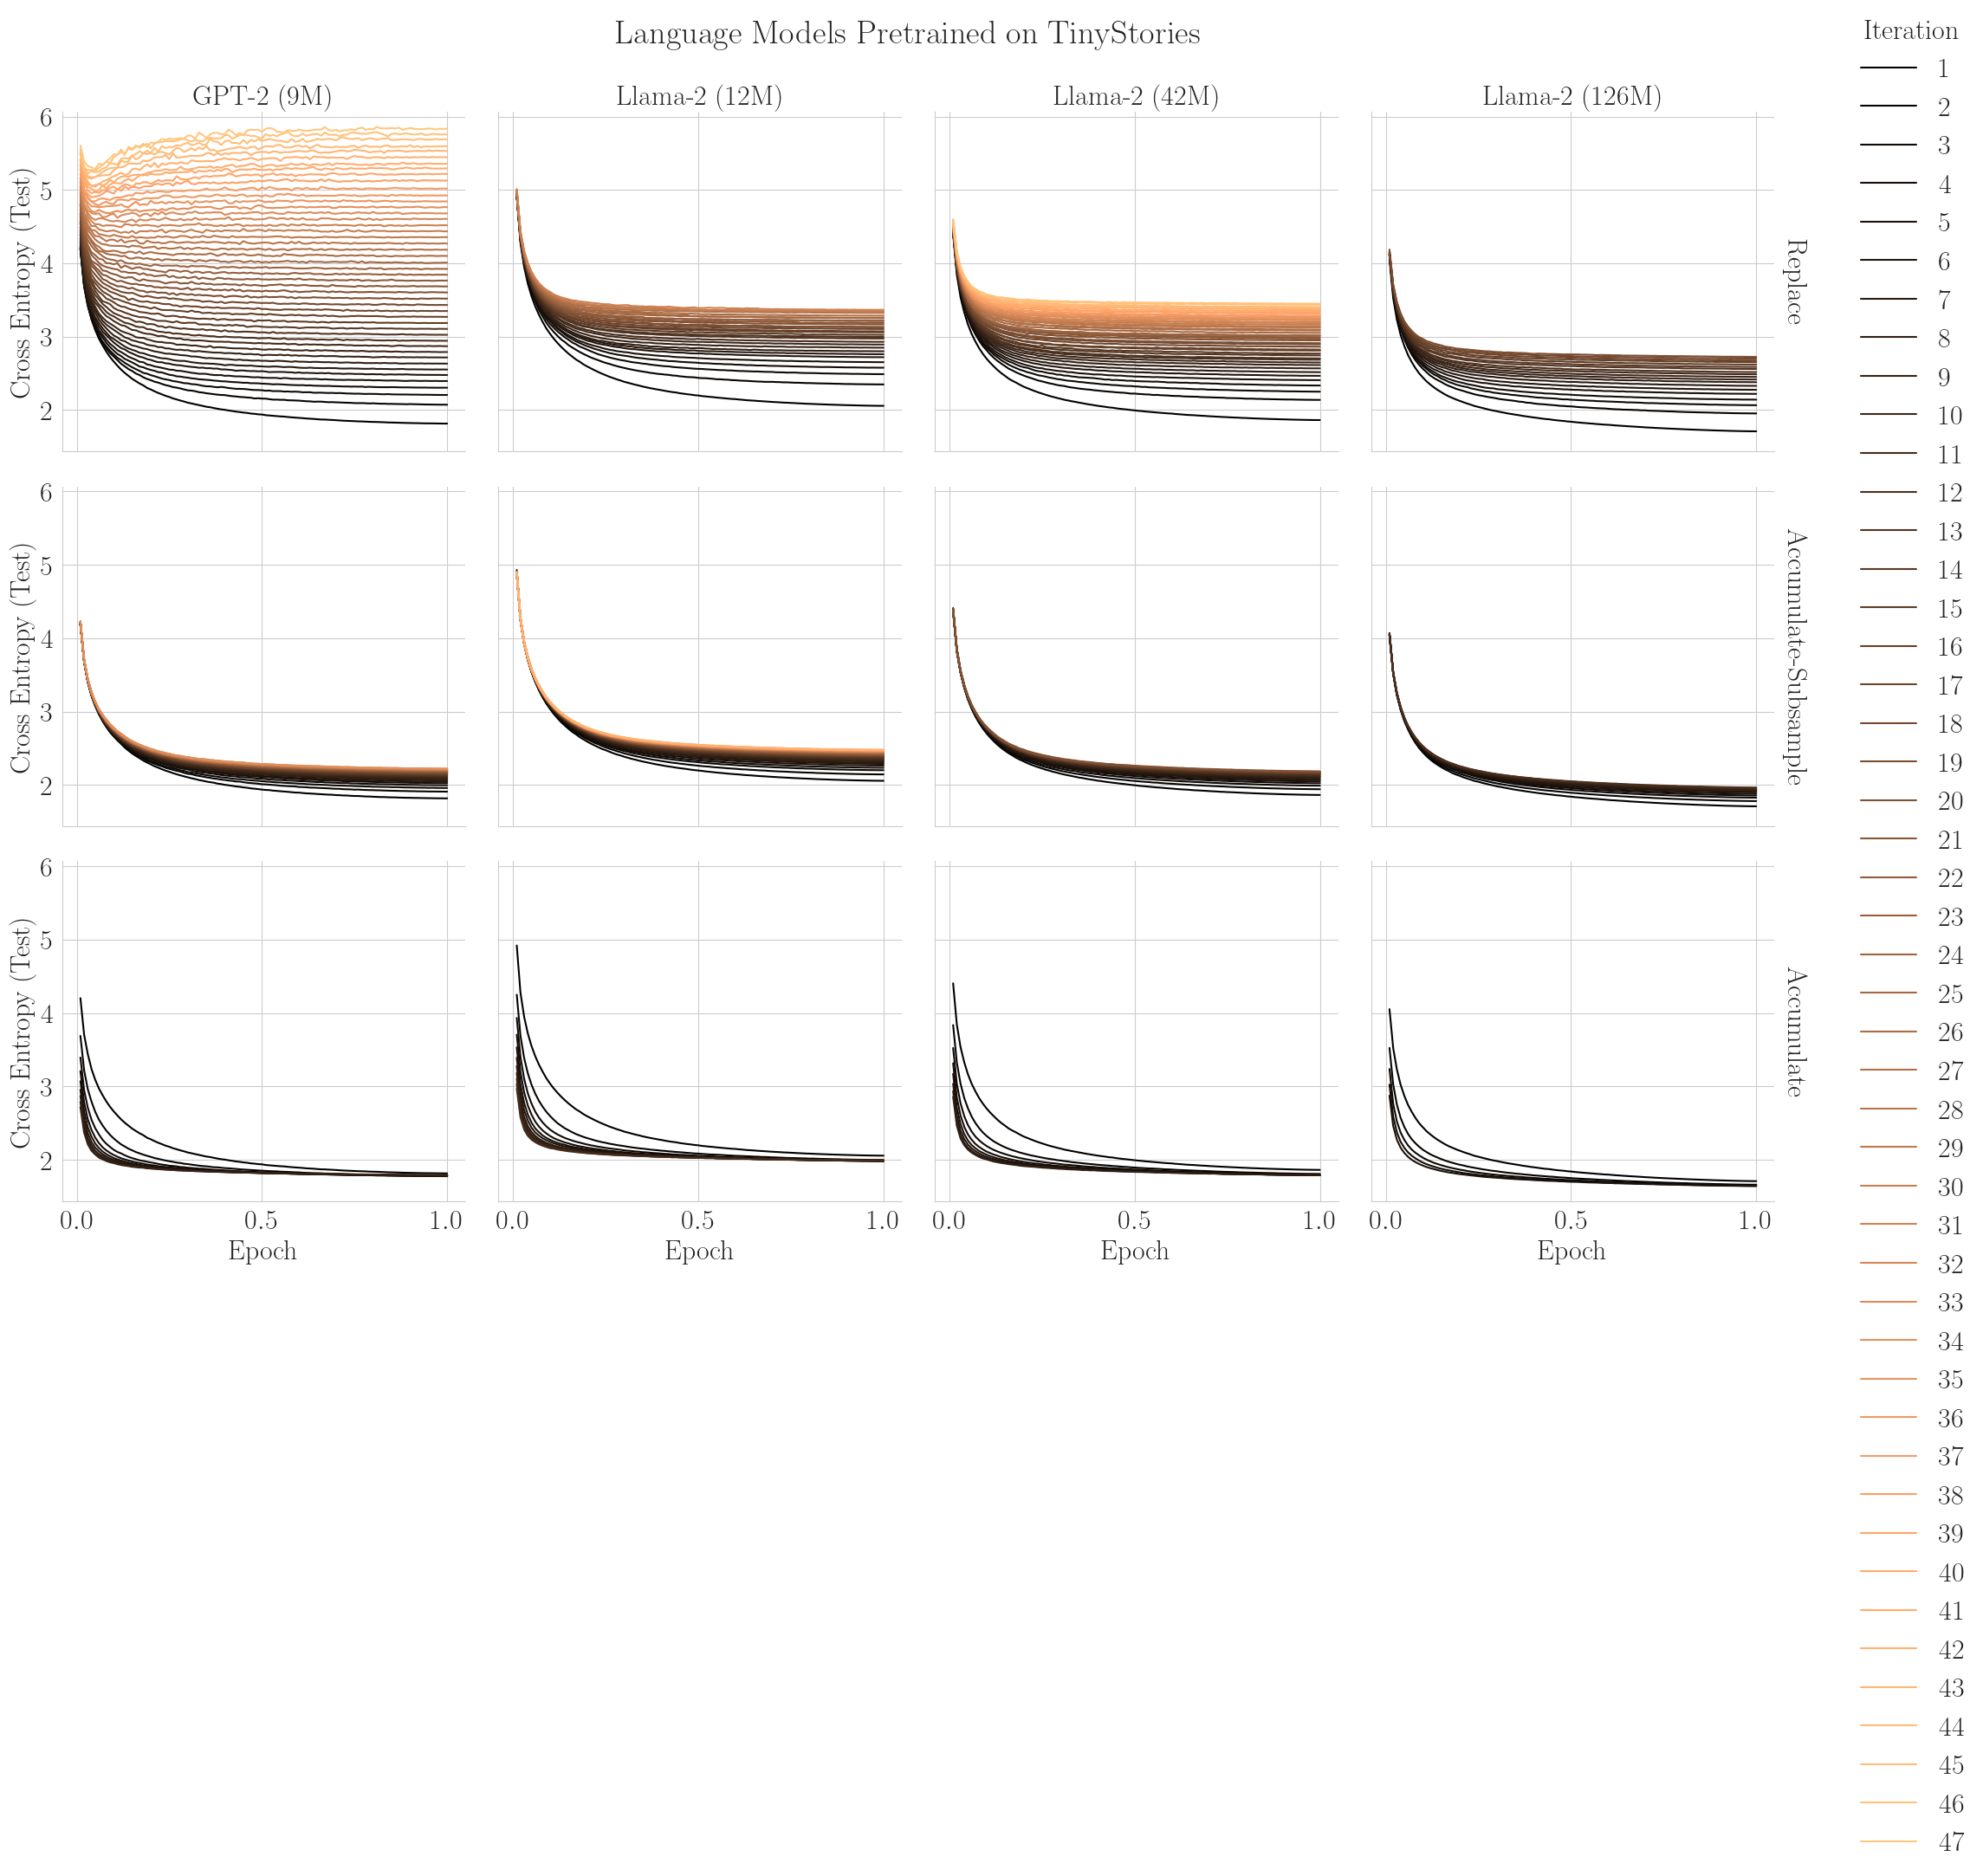

In [13]:
df_fig_1 = df_trainer_eval_loss
df_fig_1 = df_fig_1.rename(columns={"Model (long)": "Model", "Model": "Model (short)"})
df_fig_1 = df_fig_1[df_fig_1["Model"] != "Llama-2-12M"]
# Create a relplot for trainer global step vs eval loss
g = sns.relplot(
    # data=df_trainer_eval_loss[df_trainer_eval_loss["Temperature"] == 0.3],
    data=df_fig_1[df_fig_1["Temperature"] == 1.0],
    x="epoch",
    y="eval_loss",
    hue="Iteration",
    # style="Temperature",
    # style_order=[1.0, 0.3],
    row="dataset_mode",
    col="Model",
    row_order=col_order,
    kind="line",
    # palette="mako",
    palette="copper",
    # palette="crest",
    # palette="cool",
    # palette="flare",
    facet_kws={"sharey": True, "sharex": True, "margin_titles": True},
    legend="full",
)
g.set_axis_labels("Epoch", "Cross Entropy (Test)")
g.set_titles(
    col_template="{col_name}",
    row_template="{row_name}",
)
# g.map(
#     plt.axhline, y=uniform_loss, color="red", linestyle="--", label="Uniform"
# )  # Add horizontal line
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.fig.suptitle(f"Language Models Pretrained on TinyStories")
src.plot.save_plot_with_multiple_extensions(
    plot_dir=plot_dir,
    plot_filename=f"part2_eval_loss_linear_vs_epoch_linear_col_iteration_{query_datetime}",
)

plt.show()

In [14]:
cond = ((df_inner["epoch"] == 1.0) & (df_inner["num_epochs"] == 1.0)) | (
    (df_inner["epoch"] == 3.0) & (df_inner["num_epochs"] == 3.0)
)
# df_fig1_alt = df_inner[cond]
cond = df_trainer_eval_loss["epoch"] == 1.0
df_fig1_alt = df_trainer_eval_loss[cond]

# df_fig1_alt = df_fig1_alt[
#     df_fig1_alt["run_group"].isin(
#         [
#             "tinystories_1_matthias_8k_1epoch_new",
#             "tinystories_1_matthias_8k_1epoch_llama",
#             "tinystories_1_matthias_8k_1epoch_llama42M_snap",
#             "tinystories_1_matthias_8k_1epoch_llama125M_nlp",
#         ]
#     )
# ]

# df_fig1_alt = df_fig1_alt[df_fig1_alt["Iteration"] <= 5]


# We use 1-based indexing in the mathematical notation.
# df_fig1_alt["iteration"] += 1


# Rename column from "iteration" to "Iteration" for nicer plotting.
# df_fig1_alt = df_fig1_alt.rename(
#     columns={"iteration": "Iteration", "temperature": "Temperature"}
# )

Plotted results/part2_eval_loss_linear_vs_iteration_20241001.pdf
Plotted results/part2_eval_loss_linear_vs_iteration_20241001.png


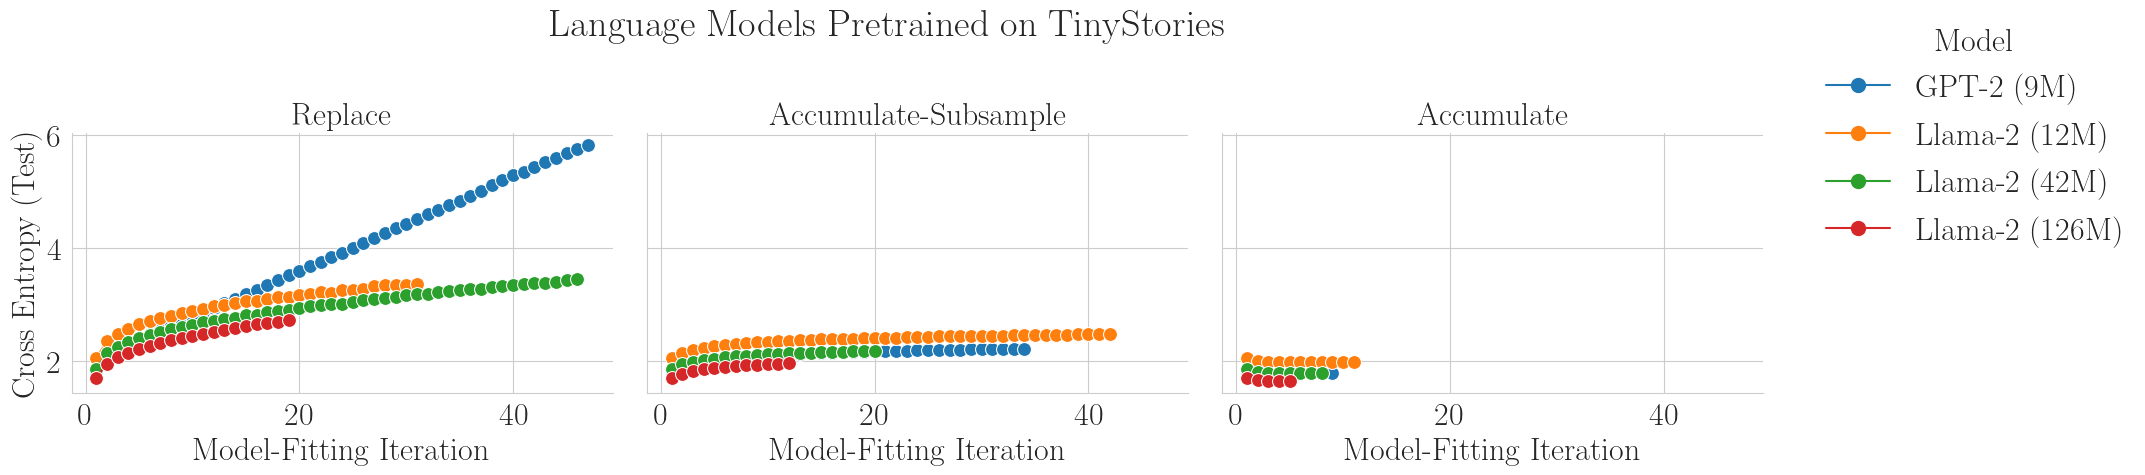

In [15]:
df_fig1_alt = df_fig1_alt
# df_fig1_alt = df_fig1_alt.rename(columns={"Model (long)": "Model", "Model": "Model (short)"})
# df_fig1_alt = df_fig1_alt[df_fig1_alt["Model"] != "Llama-2-12M"]

# Create a relplot for trainer global step vs eval loss
g = sns.relplot(
    # data=df_trainer_eval_loss[df_trainer_eval_loss["Temperature"] == 0.3],
    data=df_fig1_alt[df_fig1_alt["Temperature"] == 1.0]
    .rename(columns={"Model": "Model (short)"})
    .rename(
        columns={
            "Model (long)": "Model",
        }
    ),
    x="Iteration",
    y="eval_loss",
    # hue="Iteration",
    # style="Temperature",
    # style_order=[1.0, 0.3],
    col="dataset_mode",
    hue="Model",
    hue_order=[
        "GPT-2 (9M)",
        "Llama-2 (12M)",
        "Llama-2 (42M)",
        "Llama-2 (126M)",
    ],
    col_order=col_order,
    kind="line",
    # palette="mako",
    # palette="copper",
    # palette="crest",
    # palette="cool",
    # palette="flare",
    facet_kws={"sharey": True, "sharex": True, "margin_titles": True},
    legend="full",
    marker="o",
    markersize=10,
)
g.set_axis_labels("Model-Fitting Iteration", "Cross Entropy (Test)")
g.set_titles(
    col_template="{col_name}",
    row_template="{row_name}",
)
# g.set( yscale="log")
# g.map(
#     plt.axhline, y=uniform_loss, color="red", linestyle="--", label="Uniform"
# )  # Add horizontal line
# sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.fig.suptitle(f"Language Models Pretrained on TinyStories")
src.plot.save_plot_with_multiple_extensions(
    plot_dir=plot_dir,
    plot_filename=f"part2_eval_loss_linear_vs_iteration_{query_datetime}",
)

plt.show()

Plotted results/part2_rylan_eval_loss_linear_vs_iteration_20241001.pdf
Plotted results/part2_rylan_eval_loss_linear_vs_iteration_20241001.png


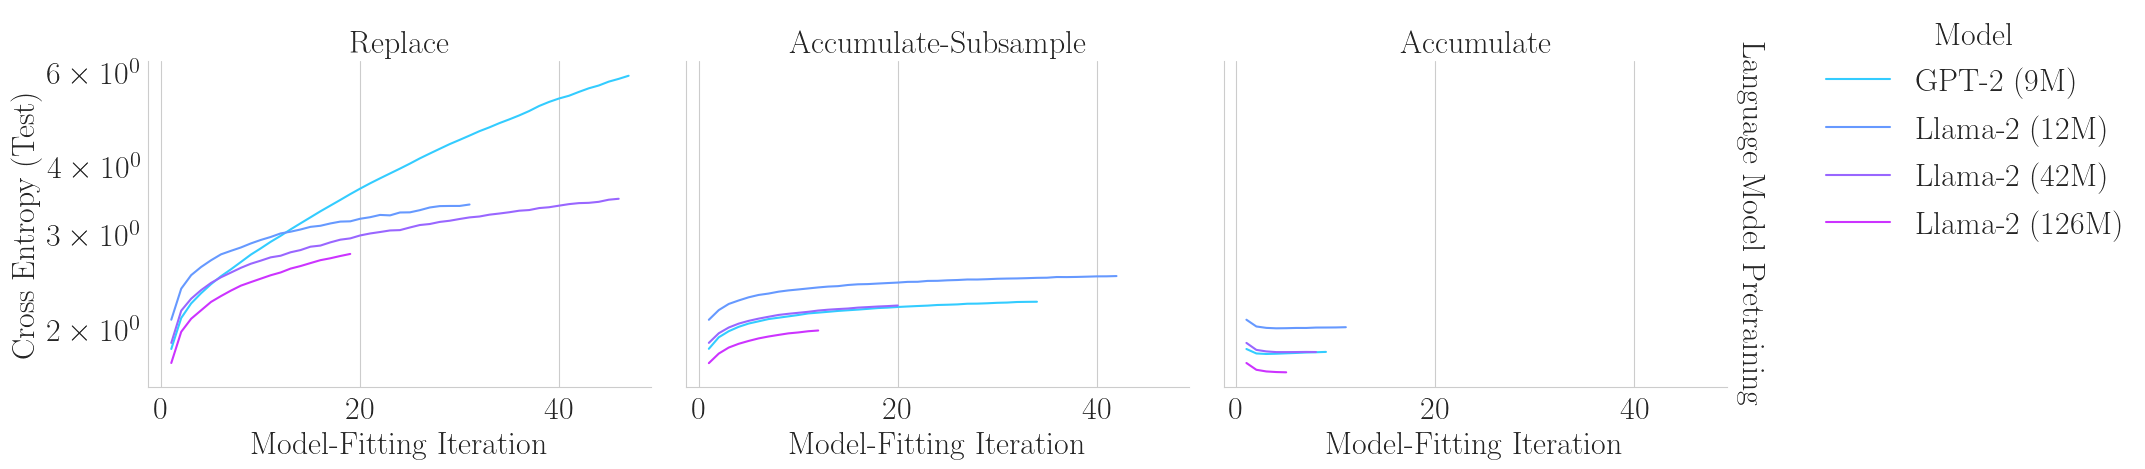

In [16]:
df_fig1_alt = df_fig1_alt.rename(columns={"Iteration": "Model-Fitting Iteration"})
# df_fig1_alt = df_fig1_alt.rename(columns={"Model (long)": "Model", "Model": "Model (short)"})
# df_fig1_alt = df_fig1_alt[df_fig1_alt["Model"] != "Llama-2-12M"]

df_for_rylan = (
    df_fig1_alt[df_fig1_alt["Temperature"] == 1.0]
    .rename(columns={"Model": "Model (short)"})
    .rename(
        columns={
            "Model (long)": "Model",
        }
    )
)

df_for_rylan["Task"] = "Language Model Pretraining"

# Create a relplot for trainer global step vs eval loss
g = sns.relplot(
    data=df_for_rylan,
    kind="line",
    x="Model-Fitting Iteration",
    y="eval_loss",
    col="dataset_mode",
    col_order=["Replace", "Accumulate-Subsample", "Accumulate"],
    row="Task",
    hue="Model",
    hue_order=[
        "GPT-2 (9M)",
        "Llama-2 (12M)",
        "Llama-2 (42M)",
        "Llama-2 (126M)",
    ],
    palette="cool",
    legend="full",
    facet_kws={"sharey": True, "sharex": True, "margin_titles": True},
)
g.set(yscale="log")
g.set_axis_labels("Model-Fitting Iteration", "Cross Entropy (Test)")
g.set_titles(
    col_template="{col_name}",
    row_template="{row_name}",
)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
src.plot.save_plot_with_multiple_extensions(
    plot_dir=plot_dir,
    plot_filename=f"part2_rylan_eval_loss_linear_vs_iteration_{query_datetime}",
)

plt.show()